# Analysis and Prediction of Arrivals

Table of Contents

1. [Importing libraries and data tables](#initiation) <br>
2. [Arrival patterns](#arrivalpatterns) <br>
3. [Seasonality](#seasonality) <br>
    3.1. [Seasonality per year](#seasonalityperyear) <br> 
    3.2. [Week factors per ship class](#weekfactorspershipclass) <br> 
    3.3. [Clustering based on week factors](#clusteringbasedonweekfactors) <br> 
    3.4. [Seasonal Autoregressive Moving Average (SARMA)](#sarma) <br> 
    3.5. [Selecting the week](#selectingtheweek) <br> 
    3.6. [Generating IMA-driven scenario](#imadrivenscenario) <br> 

Let's start by importing necessary libraries.

<a id='initiation'></a>
## 1. Importing libraries and data tables

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
hh_mm = DateFormatter('%H:%M')
import ipywidgets as widgets
from ipywidgets import Box
from tqdm import tqdm
from datetime import timedelta
plt.rcParams["font.family"] = "Times New Roman"
from scipy import stats
from sklearn import cluster
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import os
from collections import defaultdict
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import cluster

os.environ["OMP_NUM_THREADS"] = "1" 
viridis_colors=['#440154FF', '#414487FF', '#22A884FF', '#7AD151FF', '#FDE725FF']
pd_index = pd.date_range(start=datetime.date(2018, 1, 1), end=datetime.date(2022, 12, 31), freq='W')


Let's read the csv with cleaned passage data.

In [2]:
passages =  pd.read_csv("data/passages_cleaned.csv", index_col=0)
passages.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,...,sivak_class,event_end,chamber_allowed,chamber_check,week,sivak_ship_group,avg_dwt,avg_area,cargo_type,cargo_subtype
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:09:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:02:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Gas
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,...,M12 (Rijnmax),2018-01-01 03:58:00,commercial,True,1,MotorVessel,6056.0,2201.62,Tank,Tank


In [3]:
ship_classes =  pd.read_csv("data/ship_classes.csv", index_col=0)
ship_classes_dict = ship_classes.set_index('Ship Class').to_dict('index')
ship_classes_dict["M8 (Groot Rijnschip) (CEMT V)"]

{'Ship Type': 'MotorVessel',
 'Chamber': 'commercial',
 'Min Speed (km/h)': 12,
 'Max Speed (km/h)': 20,
 'Min Speed Loaded (km/h)': 10.0,
 'Max Speed Loaded (km/h)': 17,
 'UKC (m)': 0.3,
 'Height Margin (m)': 0.1,
 'Block Coefficient (%)': 80,
 'Engine Power (kW)': 1250,
 'Mean Draft Empty (m)': 0.7,
 'Residual Resistance Coefficient': 0.15,
 'Slowsteaming (%)': 80,
 'DWT': 2831.0,
 'LOA': 106.0,
 'Width': 11.32,
 'Area': 1199.92}

<a id='arrivalpatterns'></a>
## 2. Arrival patterns

In [4]:
passages['event_start'] = pd.to_datetime(passages['event_start'])
passages['hour'] = passages['event_start'].dt.hour
passages['day_of_week'] = passages['event_start'].dt.dayofweek + 1
passages.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,...,event_end,chamber_allowed,chamber_check,week,sivak_ship_group,avg_dwt,avg_area,cargo_type,cargo_subtype,day_of_week
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,2018-01-01 02:09:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,...,2018-01-01 02:02:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Gas,1
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,...,2018-01-01 03:58:00,commercial,True,1,MotorVessel,6056.0,2201.62,Tank,Tank,1


In [5]:
days_hours_df = pd.DataFrame(passages.groupby(['direction_id', 'day_of_week', 'hour']).size()).reset_index()
days_hours_df.head()

,direction_id,day_of_week,hour,0
0,1,1,0,630
1,1,1,1,572
2,1,1,2,550
3,1,1,3,575
4,1,1,4,535


In [6]:
north= days_hours_df[days_hours_df['direction_id']==1][0]
south= days_hours_df[days_hours_df['direction_id']==3][0]
_, p_value_paired = stats.ttest_rel(north,south)
if p_value_paired <0.05:
    print("Reject the hypothesis that the related observations have the same mean")
else:
    print("Fail to reject the hypothesis that the related observations have the same mean")

Reject the hypothesis that the related observations have the same mean


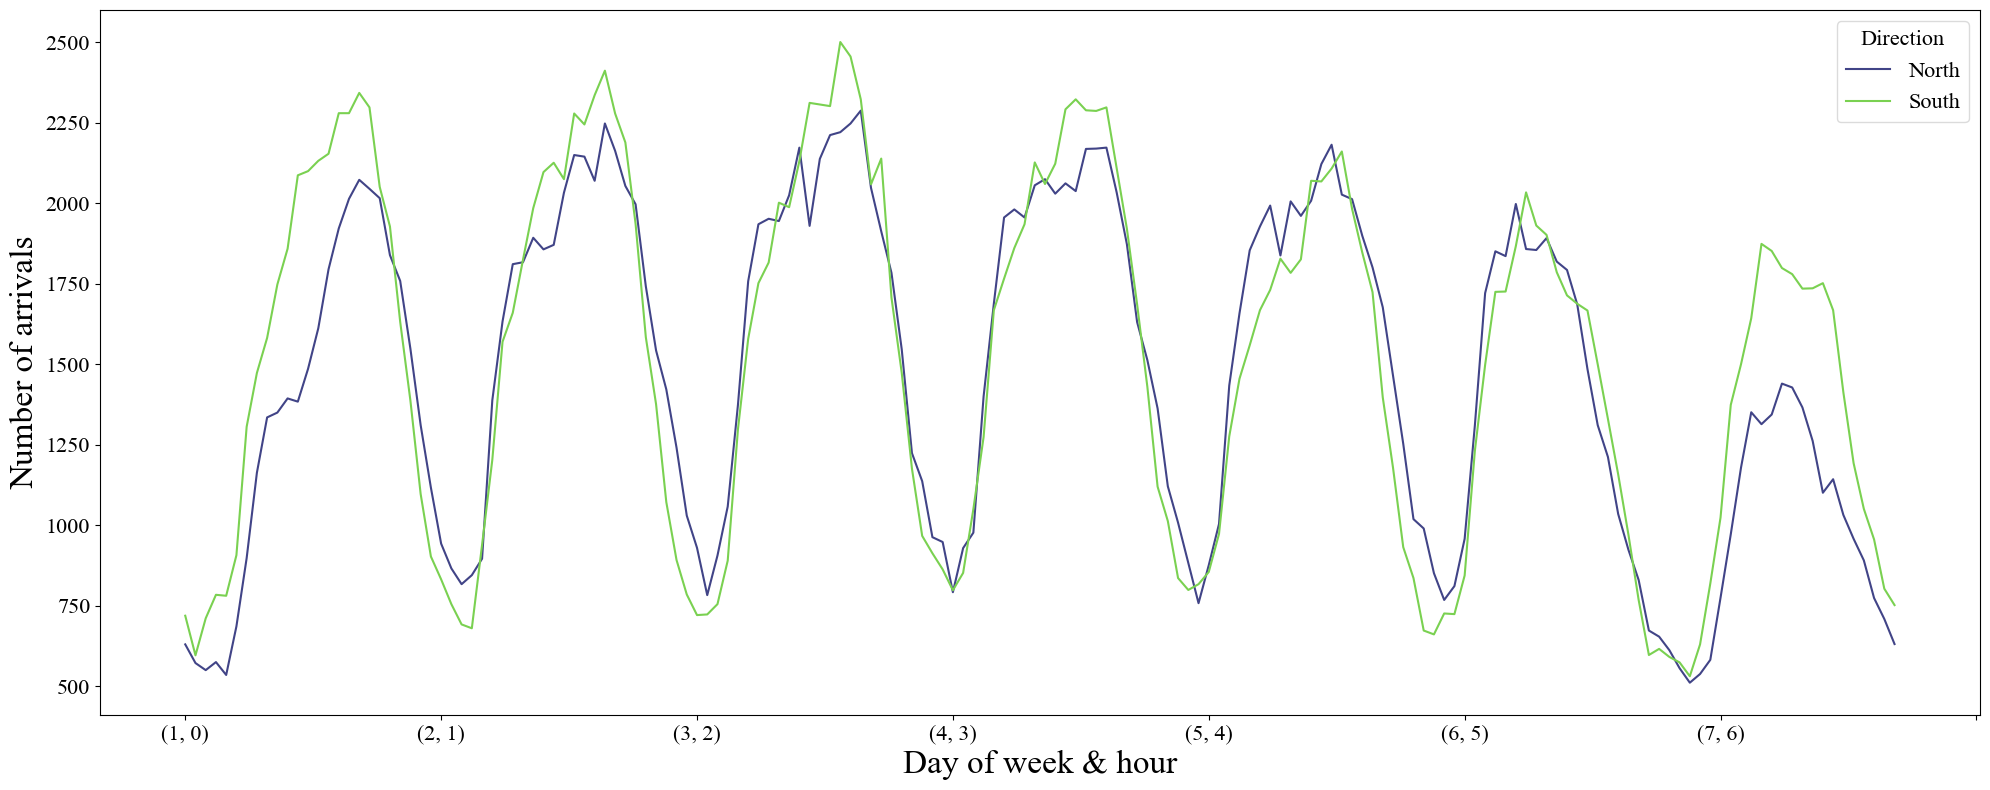

In [7]:
direction_dict={1: ['Noord', 'North'], 3: ['Zuid', 'South']}

fig, ax = plt.subplots(figsize=(20,8))
for direction_id in [1,3]:
    passages[passages['direction_id']==direction_id].groupby(['day_of_week', 'hour']).size().plot(label=direction_dict[direction_id][1], 
                                                                                                  color=viridis_colors[direction_id])

legend = ax.legend(fontsize=16, loc="upper right", title='Direction')
legend.get_title().set_fontsize(16)
legend.get_frame().set_alpha(0.7)

ax.set_xlabel("Day of week & hour", fontsize=24)
ax.set_ylabel("Number of arrivals", fontsize=24)
ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig("output/figs/arrival_analysis_prediction/arrival_pattern.pdf")
plt.show()

In [8]:
arrival_pattern = pd.pivot_table(days_hours_df, 
               values=0, 
               index=['direction_id', 'day_of_week'],
               columns=['hour'], 
               aggfunc=np.sum
               ).reset_index()

arrival_pattern['direction_id'] = arrival_pattern.apply(lambda x: 'Commercial-' + direction_dict[x['direction_id']][1][0], axis=1)
arrival_pattern = arrival_pattern.reindex(columns=['direction_id', 'day_of_week'] + list(range(24)))
arrival_pattern.rename(columns={'direction_id': 'Arrival Pattern', 'day_of_week': 'Day Nr'}, inplace=True)
arrival_pattern.to_csv("output/tables/arrival_pattern.csv")

arrival_pattern.head()

hour,Arrival Pattern,Day Nr,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,Commercial-N,1,630,572,550,575,535,686,898,1163,...,1795,1922,2014,2073,2045,2016,1839,1759,1548,1311
1,Commercial-N,2,1117,943,866,817,845,896,1388,1633,...,2150,2145,2070,2248,2163,2054,1997,1742,1543,1422
2,Commercial-N,3,1241,1030,930,783,906,1058,1374,1758,...,2138,2212,2221,2248,2288,2048,1913,1784,1547,1224
3,Commercial-N,4,1137,963,948,792,929,977,1400,1688,...,2062,2038,2169,2170,2173,2034,1873,1631,1513,1363
4,Commercial-N,5,1121,1008,883,758,876,1004,1434,1658,...,2008,2122,2182,2027,2013,1899,1801,1677,1464,1253


<a id='seasonality'></a>
## 3. Seasonality

<a id='seasonalityperyear'></a>
### 3.1. Seasonality per year

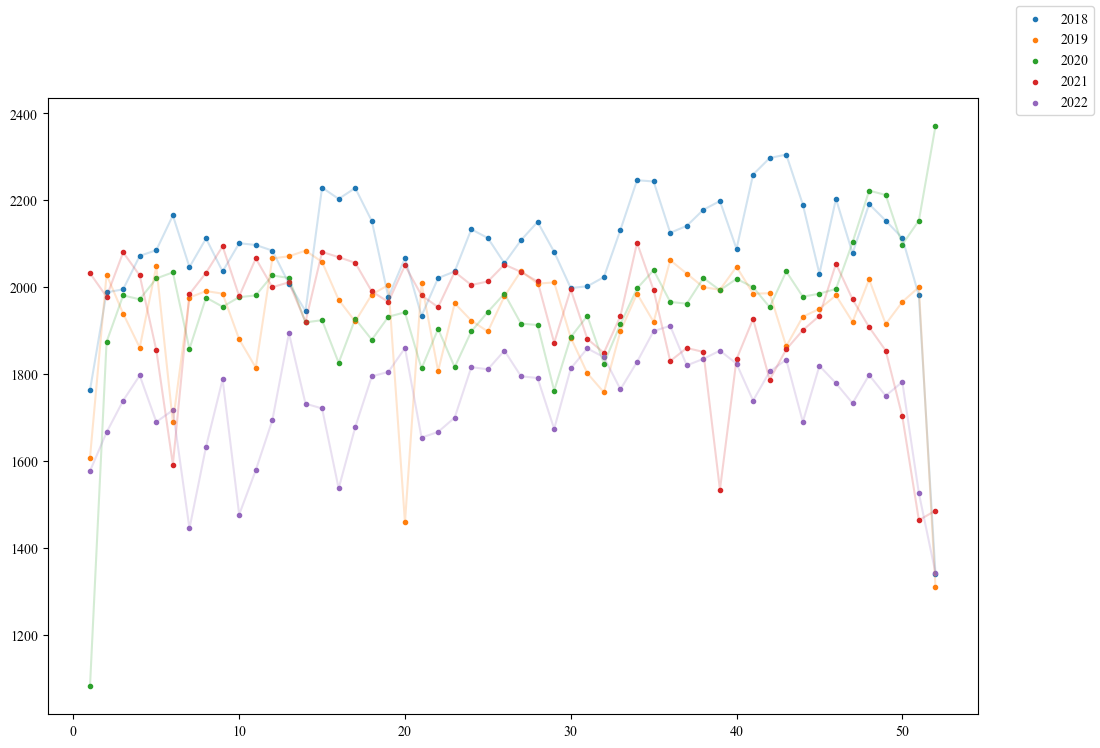

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
for year in [2018,2019,2020,2021,2022]:
    plt.scatter(y= passages.groupby(['year', 'week']).size()[year], x=range(1,53), label=year, marker='.', cmap='viridis')
    plt.plot(passages.groupby(['year', 'week']).size()[year], alpha=0.2)
fig.legend()

<a id='weekfactorspershipclass'></a>
### 3.2. Week factors per ship class

Week factors are a way the express seasonality for ships over the year. For every week of the year, week factor is the ratio between the observed ship arrivals in that week and the weekly average over the year. If it is 1.1, it means that there are on 10% more ship arrivals in that week compared to the weekly average.

In [10]:
weeks_df_ships = pd.DataFrame(passages.groupby(['sivak_class', 'week']).size()).reset_index()
weeks_df_ships.rename(columns={0:'number_ships'}, inplace=True)
print(len(weeks_df_ships))
for ship_checked in passages['sivak_class'].unique():
    for week_checked in range(1,53):
        if(len(weeks_df_ships[(weeks_df_ships['week']==week_checked) & (weeks_df_ships['sivak_class']==ship_checked)]['number_ships'])==0):
            weeks_df_ships = weeks_df_ships.append(pd.DataFrame({"sivak_class":[ship_checked], 'week':[week_checked], 'number_ships':[0]}), ignore_index = True)
print(len(weeks_df_ships))
weeks_df_ships.head()

1862
1976


,sivak_class,week,number_ships
0,BI-1 duwstel Europa I (IV),1,27
1,BI-1 duwstel Europa I (IV),2,26
2,BI-1 duwstel Europa I (IV),3,30
3,BI-1 duwstel Europa I (IV),4,35
4,BI-1 duwstel Europa I (IV),5,25


If there is less than 4 weekly arrivals on average for the ships of a type, I will filter this ship out for now. I will still predict arrivals for these ships, but I will leave them out from the figures and clustering analysis. 

In [11]:
for ship in weeks_df_ships['sivak_class'].unique():
    if weeks_df_ships[weeks_df_ships['sivak_class'] == ship]['number_ships'].sum() < 5*52*4:
        weeks_df_ships.drop(weeks_df_ships[weeks_df_ships.sivak_class == ship].index, inplace=True)
        print('Observations deleted for', ship)
print(len(weeks_df_ships))

Observations deleted for BII-2l 2 baks duwstel Europa II (lange form)
Observations deleted for BII-6l duwstel Eur II 6b lang
Observations deleted for BO1 duwstel
Observations deleted for BO2 duwstel
Observations deleted for BO3 duwstel
Observations deleted for BO4 duwstel
Observations deleted for C1-l, koppelverband, 2 spitsen (lang) (I)
Observations deleted for C1b, koppelverband, 2 spitsen breed
Observations deleted for C2b, koppelverband, IV + Eur I breed
Observations deleted for M0 (overig)
Observations deleted for M2-Container (Kempenaar) 2-laags
Observations deleted for M6-Container (Rijn-Herne) 3-laags
1352


In [12]:
class_average = {}
for ship_class in list(weeks_df_ships.sivak_class.unique()):
    class_average[ship_class]= weeks_df_ships[weeks_df_ships['sivak_class']==ship_class]['number_ships'].mean()

In [13]:
weeks_df_ships['week_factor'] = weeks_df_ships.apply(lambda x: x['number_ships']/class_average[x['sivak_class']], axis=1)
weeks_df_ships['ship_type'] = weeks_df_ships.apply(lambda x: ship_classes_dict[x['sivak_class']]['Ship Type'], axis=1)
weeks_df_ships.head()

,sivak_class,week,number_ships,week_factor,ship_type
0,BI-1 duwstel Europa I (IV),1,27,0.860294,PushTow
1,BI-1 duwstel Europa I (IV),2,26,0.828431,PushTow
2,BI-1 duwstel Europa I (IV),3,30,0.955882,PushTow
3,BI-1 duwstel Europa I (IV),4,35,1.115196,PushTow
4,BI-1 duwstel Europa I (IV),5,25,0.796569,PushTow


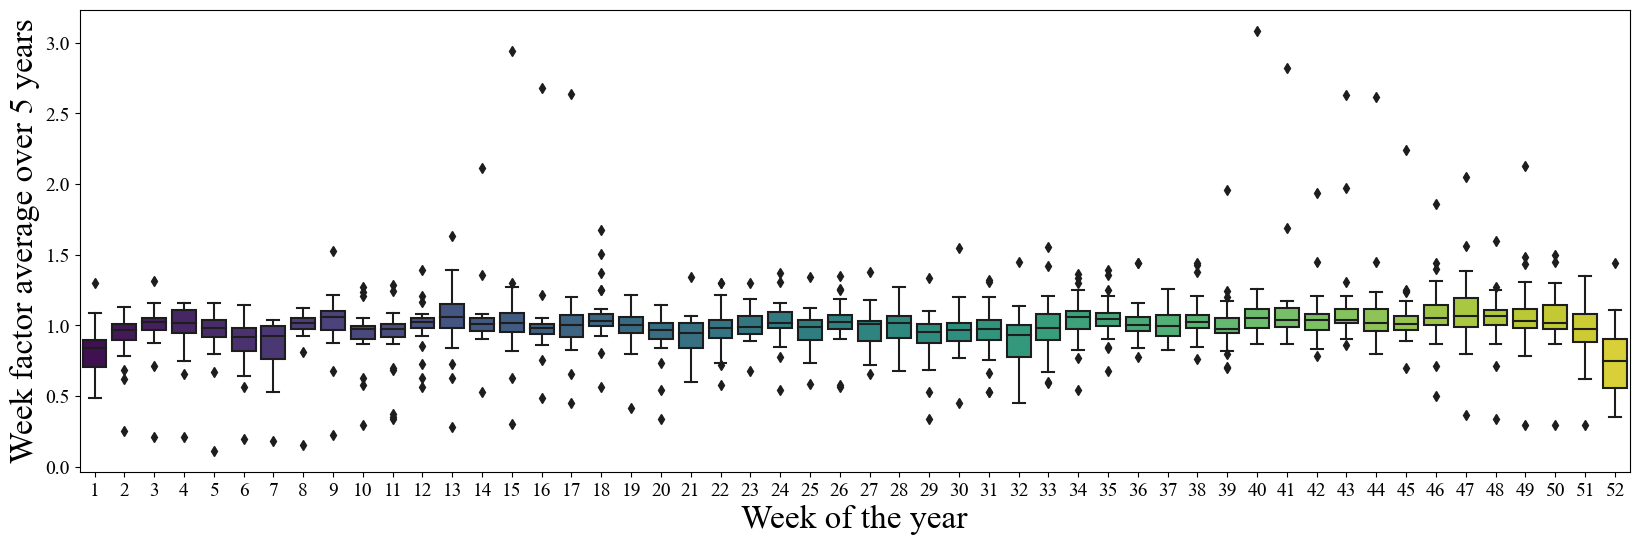

In [14]:
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(data=weeks_df_ships, x='week', y='week_factor', ax =ax, palette='viridis')
ax.set_xlabel("Week of the year",fontsize=24)
ax.set_ylabel("Week factor average over 5 years",fontsize=24)
ax.tick_params(labelsize=14)
plt.savefig("output/figs/arrival_analysis_prediction/seasonality_weekfactors_boxplot.pdf")
plt.show()

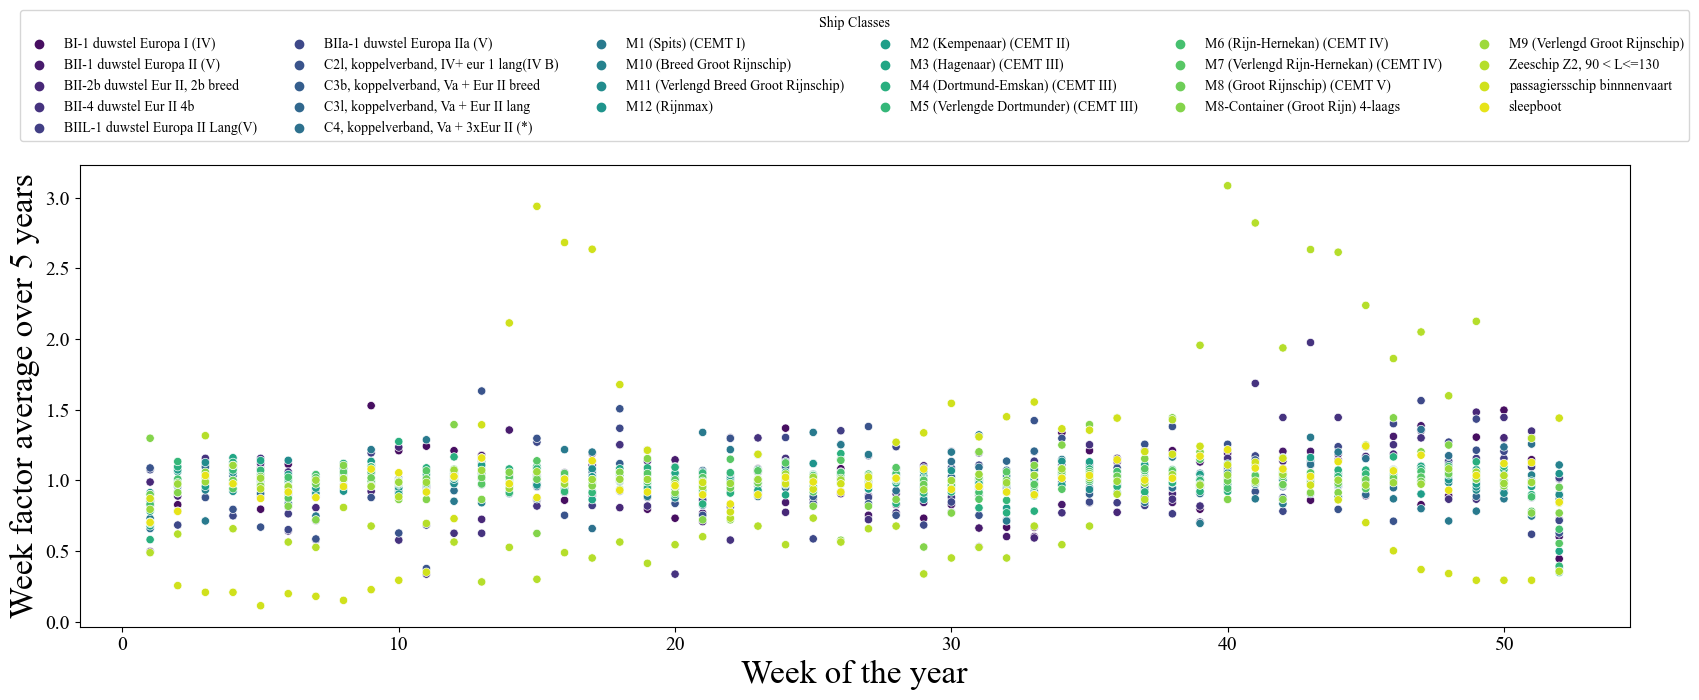

In [15]:
fig, ax = plt.subplots(figsize=(20,6))
sns.scatterplot(data=weeks_df_ships, x='week', y='week_factor', hue='sivak_class', ax =ax, palette='viridis')
ax.set_xlabel("Week of the year",fontsize=24)
ax.set_ylabel("Week factor average over 5 years",fontsize=24)
ax.tick_params(labelsize=14)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.35), ncol=6, title='Ship Classes')
plt.savefig("output/figs/arrival_analysis_prediction/seasonality_weekfactors_shipclasss_scatter.pdf", bbox_inches='tight')
plt.show()

<a id='clusteringbasedonweekfactors'></a>
### 3.3. Clustering based on week factors

In [16]:
weeks_df_ships_filtered = weeks_df_ships
for ship in weeks_df_ships_filtered['sivak_class'].unique():
    if weeks_df_ships_filtered[weeks_df_ships_filtered['sivak_class'] == ship]['number_ships'].sum() < 5*52*4:
        weeks_df_ships_filtered.drop(weeks_df_ships_filtered[weeks_df_ships_filtered.sivak_code == ship].index, inplace=True)
        print('Observations deleted for', ship)

In [17]:
weeks_df_ships_pivot = pd.pivot_table(weeks_df_ships, values='week_factor', index='sivak_class', columns='week').fillna(0)
weeks_df_ships_pivot.head()

week,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
sivak_class,,,,,,,,,,,,,,,,,,,,,
BI-1 duwstel Europa I (IV),0.860294,0.828431,0.955882,1.115196,0.796569,1.115196,0.892157,1.051471,1.529412,1.210784,...,0.860294,0.955882,0.892157,1.019608,0.828431,0.892157,1.306373,1.497549,1.147059,0.446078
BII-1 duwstel Europa II (V),0.497536,0.904610,1.130763,1.130763,1.085532,0.814149,1.025225,1.085532,1.115686,1.010148,...,1.206147,1.145839,1.025225,1.311685,1.387069,1.010148,0.995071,1.296608,0.979994,0.603073
"BII-2b duwstel Eur II, 2b breed",0.988906,0.890016,1.104279,1.087797,1.120761,0.642789,0.807607,1.021870,0.922979,1.236133,...,1.038352,1.186688,1.170206,1.186688,1.351506,1.137242,1.483360,1.302060,1.302060,0.725198
BII-4 duwstel Eur II 4b,0.867470,0.963855,1.156627,1.156627,1.156627,1.060241,0.578313,1.012048,1.108434,0.578313,...,1.975904,1.445783,0.963855,1.253012,1.301205,0.867470,0.867470,1.445783,1.349398,1.012048
BIIL-1 duwstel Europa II Lang(V),0.822909,0.999246,0.881688,1.097212,0.960060,0.764130,0.881688,1.018839,1.195177,0.940467,...,1.116805,0.960060,0.999246,1.077619,1.077619,1.136398,1.155991,1.155991,1.097212,1.018839


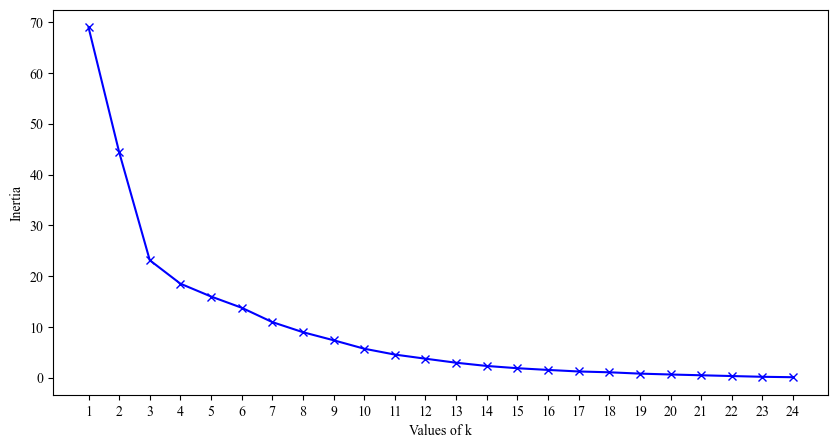

In [18]:
kmeans_models = {}
kmeans_models_inertia = {} #"Inertia is the sum of squared distances of samples to their closest cluster center."
k_range = range(1,25)
for k in k_range:
    kmeans_models[k] = cluster.KMeans(n_clusters=k).fit(weeks_df_ships_pivot.iloc[:,:-1])
    kmeans_models_inertia[k] = kmeans_models[k].inertia_

f, ax = plt.subplots(1, figsize=(10, 5))
ax.set_xticks(k_range)
plt.plot(kmeans_models_inertia.keys(),kmeans_models_inertia.values(), 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Inertia')
plt.savefig("output/figs/arrival_analysis_prediction/clustering_elbow.pdf")

plt.show()

Elbow method suggests to pick the k where the decrease in inertia slows down significantly. So, k=3 is selected.

In [19]:
kmeans_model_selected= kmeans_models[3]
weeks_df_ships_pivot["Cluster"] = kmeans_model_selected.labels_
weeks_df_ships_pivot.head()

week,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,Cluster
sivak_class,,,,,,,,,,,,,,,,,,,,,
BI-1 duwstel Europa I (IV),0.860294,0.828431,0.955882,1.115196,0.796569,1.115196,0.892157,1.051471,1.529412,1.210784,...,0.955882,0.892157,1.019608,0.828431,0.892157,1.306373,1.497549,1.147059,0.446078,0
BII-1 duwstel Europa II (V),0.497536,0.904610,1.130763,1.130763,1.085532,0.814149,1.025225,1.085532,1.115686,1.010148,...,1.145839,1.025225,1.311685,1.387069,1.010148,0.995071,1.296608,0.979994,0.603073,0
"BII-2b duwstel Eur II, 2b breed",0.988906,0.890016,1.104279,1.087797,1.120761,0.642789,0.807607,1.021870,0.922979,1.236133,...,1.186688,1.170206,1.186688,1.351506,1.137242,1.483360,1.302060,1.302060,0.725198,0
BII-4 duwstel Eur II 4b,0.867470,0.963855,1.156627,1.156627,1.156627,1.060241,0.578313,1.012048,1.108434,0.578313,...,1.445783,0.963855,1.253012,1.301205,0.867470,0.867470,1.445783,1.349398,1.012048,0
BIIL-1 duwstel Europa II Lang(V),0.822909,0.999246,0.881688,1.097212,0.960060,0.764130,0.881688,1.018839,1.195177,0.940467,...,0.960060,0.999246,1.077619,1.077619,1.136398,1.155991,1.155991,1.097212,1.018839,0


In [20]:
cluster_dict = defaultdict(None)
cluster_dict = pd.Series(weeks_df_ships_pivot['Cluster']).to_dict(into=cluster_dict)

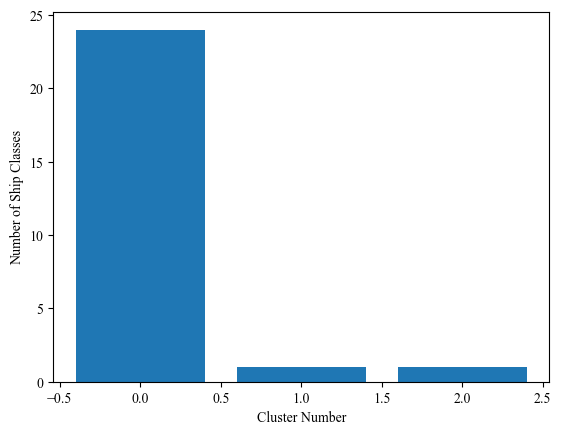

In [21]:
plt.bar(weeks_df_ships_pivot.groupby("Cluster").size().index, weeks_df_ships_pivot.groupby("Cluster").size())
plt.xlabel('Cluster Number')
plt.ylabel('Number of Ship Classes')
plt.savefig("output/figs/arrival_analysis_prediction/number_clusters.pdf")
plt.show()

In [22]:
weeks_df_ships['cluster'] = weeks_df_ships.apply(lambda x: cluster_dict.get(x['sivak_class']), axis=1)
print(f"Ship in the first class is {weeks_df_ships[weeks_df_ships['cluster']==1]['sivak_class'].unique()}")
print(f"Ship in the second class is {weeks_df_ships[weeks_df_ships['cluster']==2]['sivak_class'].unique()}")

Ship in the first class is ['passagiersschip binnnenvaart']
Ship in the second class is ['Zeeschip Z2, 90 < L<=130']


In [23]:
cluster_names = {0: 'IWT cluster', 1: 'Passenger ships', 2: 'Ocean going ships'}
weeks_df_ships['cluster_name'] = weeks_df_ships.apply(lambda x: cluster_names.get(x['cluster']), axis=1)

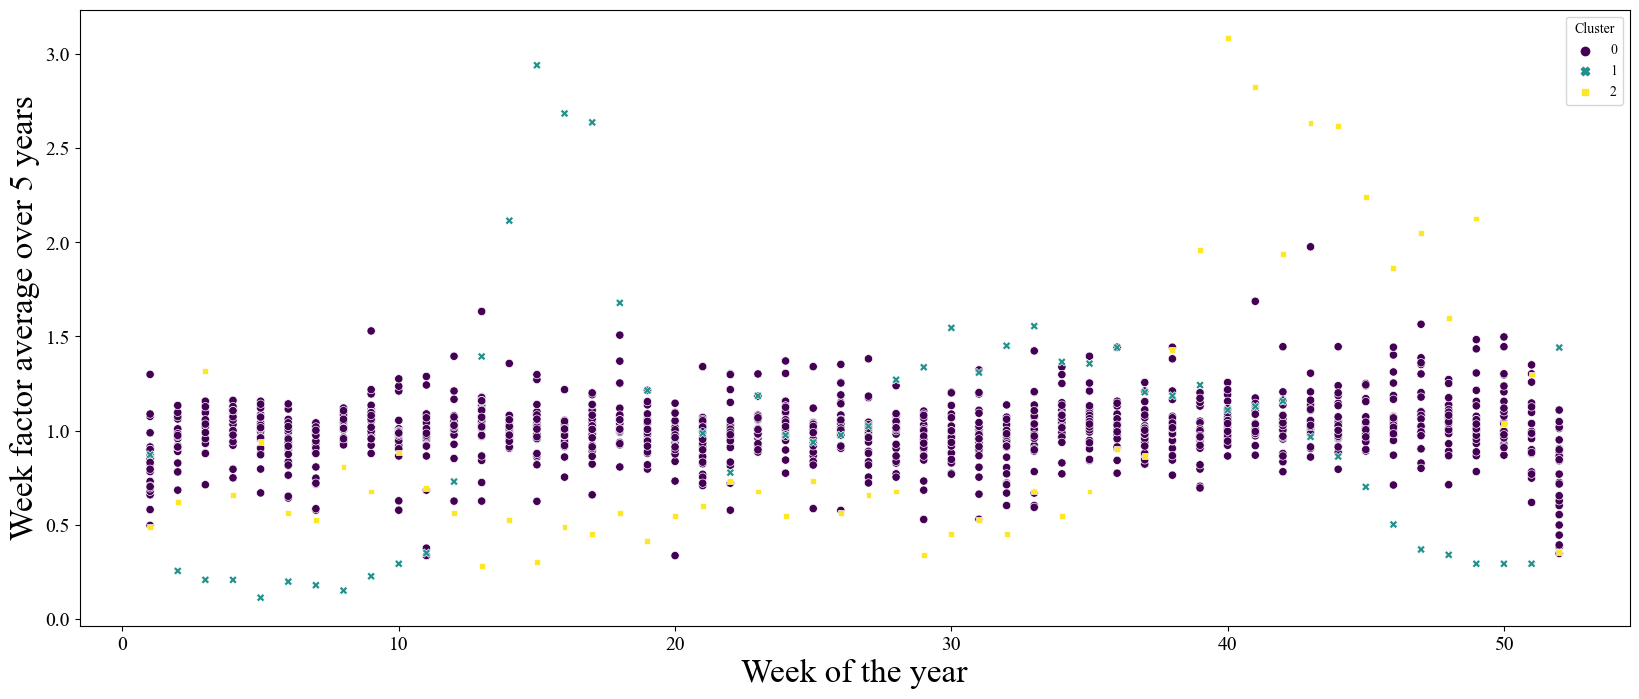

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
g = sns.scatterplot(data=weeks_df_ships, x='week', y='week_factor', hue='cluster', style='cluster', palette='viridis', ax =ax)
ax.set_xlabel("Week of the year",fontsize=24)
ax.set_ylabel("Week factor average over 5 years",fontsize=24)
ax.tick_params(labelsize=14)

plt.legend(title='Cluster', loc='upper right')
plt.savefig("output/figs/arrival_analysis_prediction/week_factor_clustered.pdf")
plt.show()

In [25]:
passages_clustered = passages
passages_clustered['cluster'] = passages.apply(lambda x: cluster_dict.get(x['sivak_class']), axis=1)
passages_clustered.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,...,chamber_allowed,chamber_check,week,sivak_ship_group,avg_dwt,avg_area,cargo_type,cargo_subtype,day_of_week,cluster
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1,0.0
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1,0.0
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank,1,0.0
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,...,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Gas,1,0.0
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,...,commercial,True,1,MotorVessel,6056.0,2201.62,Tank,Tank,1,0.0


In [26]:
weeks_df_clusters = pd.DataFrame(passages_clustered.groupby(['year', 'week', 'cluster']).size()).reset_index()
weeks_df_clusters.rename(columns={0:'number_ships'}, inplace=True)
weeks_df_clusters.head()

,year,week,cluster,number_ships
0,2018,1,0.0,1722
1,2018,1,1.0,25
2,2018,1,2.0,6
3,2018,2,0.0,1966
4,2018,2,1.0,7


In [27]:
print(len(weeks_df_clusters))
for year_checked in range(2018,2023):
    for week_checked in range(1,53):
        for cluster_checked in weeks_df_clusters['cluster'].unique():
            if(len(weeks_df_clusters[(weeks_df_clusters['year']==year_checked) & (weeks_df_clusters['week']==week_checked) & (weeks_df_clusters['cluster']==cluster_checked)]['number_ships'])==0):
                weeks_df_clusters = weeks_df_clusters.append(pd.DataFrame({"year": [year_checked], 'week':[week_checked], "cluster":[cluster_checked], 'number_ships':[0]}), ignore_index = True)
print(len(weeks_df_clusters))


755
780


In [28]:
yearly_average_cluster = {}
for cluster in weeks_df_clusters['cluster'].unique():
    yearly_average_cluster[cluster]= {}
    for year in range(2018,2023):
        yearly_average_cluster[cluster][year] = weeks_df_clusters[(weeks_df_clusters['year']==year) & (weeks_df_clusters['cluster']==cluster)]['number_ships'].mean()

In [29]:
weeks_df_clusters['week_factor'] = weeks_df_clusters.apply(lambda x: x['number_ships']/yearly_average_cluster[x['cluster']][x['year']], axis=1)
weeks_df_clusters['week_cumulative'] = weeks_df_clusters.apply(lambda x: (x['year'] - 2018)*52 + x['week'], axis=1) 
weeks_df_clusters = weeks_df_clusters.sort_values('week_cumulative')

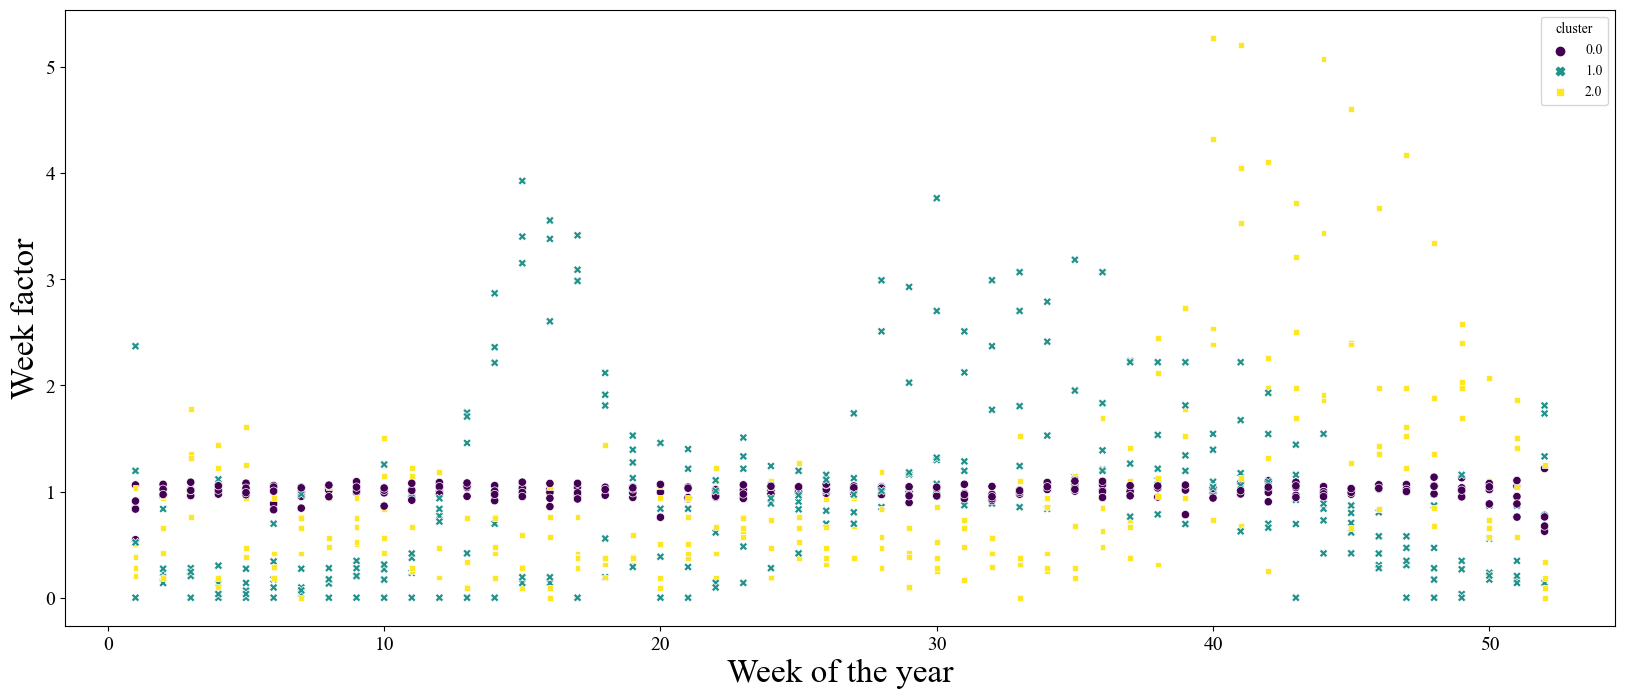

In [30]:
fig, ax = plt.subplots(figsize=(20,8))
sns.scatterplot(data=weeks_df_clusters, x='week', y='week_factor', ax =ax, hue='cluster', palette='viridis', style='cluster')
ax.set_xlabel("Week of the year",fontsize=24)
ax.set_ylabel("Week factor",fontsize=24)
ax.tick_params(labelsize=14)
plt.savefig("output/figs/arrival_analysis_prediction/seasonality_weekfactors_cluster_scatter.pdf")

plt.show()

In [31]:
cluster_ts = {}
for cluster_checked in weeks_df_clusters['cluster'].unique():
    cluster_ts[cluster_checked] = weeks_df_clusters[weeks_df_clusters['cluster']==cluster_checked].loc[:,['week_cumulative','number_ships']]
    cluster_ts[cluster_checked] = cluster_ts[cluster_checked].sort_values('week_cumulative').set_index('week_cumulative')

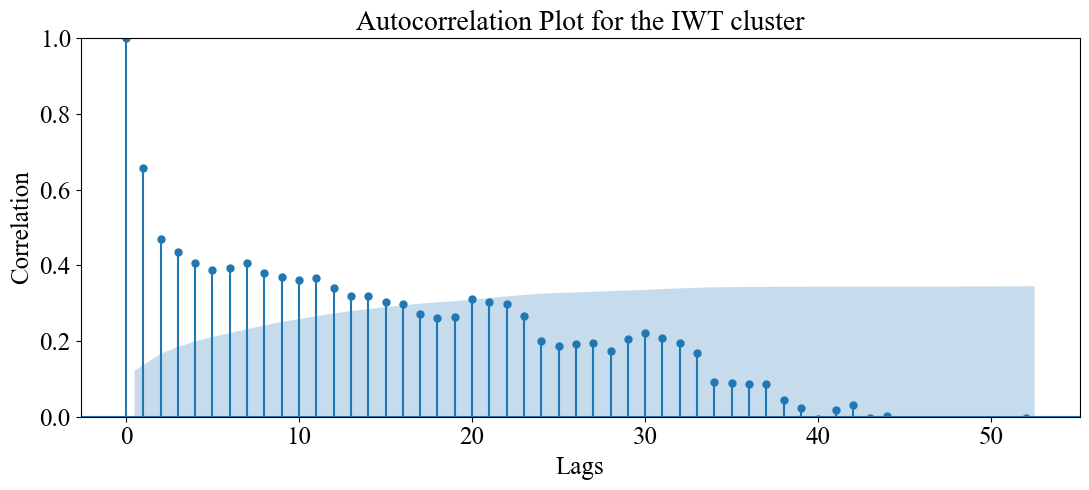

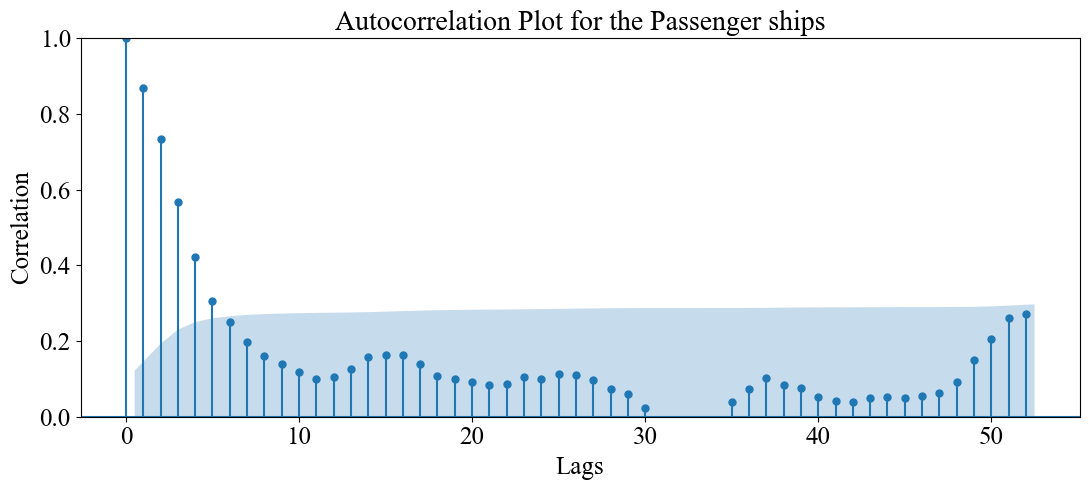

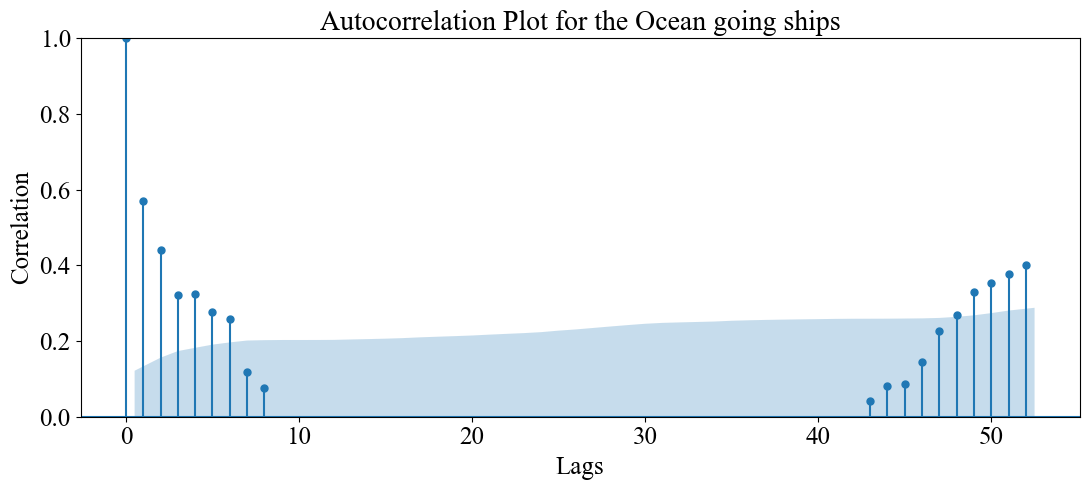

In [32]:
for cluster_checked in weeks_df_clusters['cluster'].unique():
    # Plot autocorrelation
    plt.rc("figure", figsize=(11,5))
    plot_acf(cluster_ts[cluster_checked]['number_ships'], lags=52)
    plt.ylim(0,1)
    plt.xlabel('Lags', fontsize=18)
    plt.ylabel('Correlation', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Autocorrelation Plot for the ' +  cluster_names[cluster_checked], fontsize=20)
    plt.tight_layout()
    plt.savefig('output/figs/arrival_analysis_prediction/acf_cluster_' + str(cluster_checked) + '.pdf')
    plt.show()

    X_train = cluster_ts[cluster_checked]['number_ships']
    # print(X_train.autocorr(lag=52))
    # res = sm.tsa.acf(X_train, nlags=52)
    # print(res)

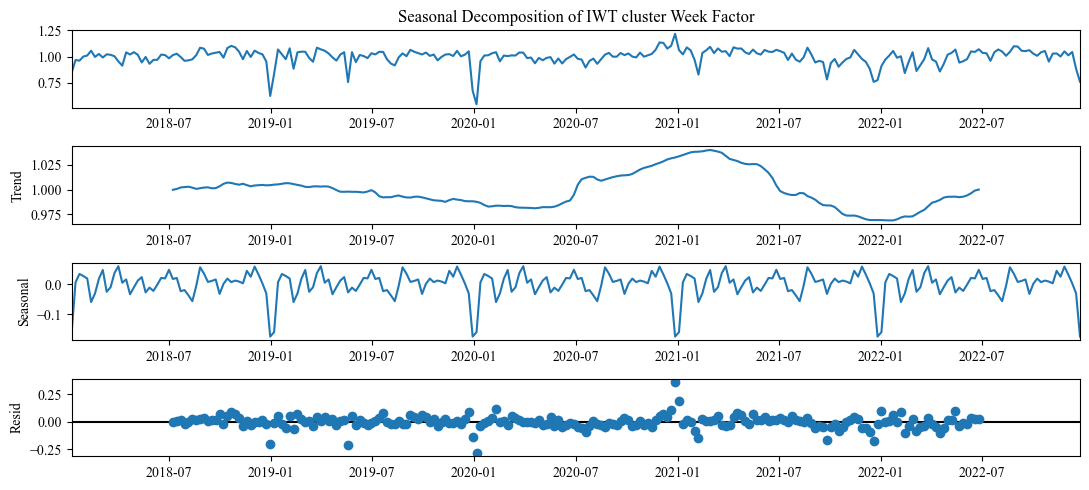

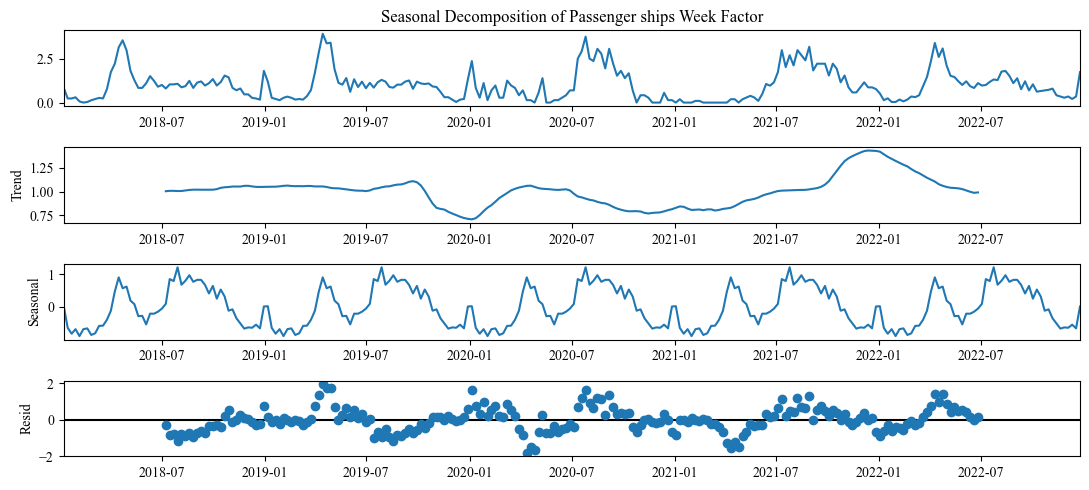

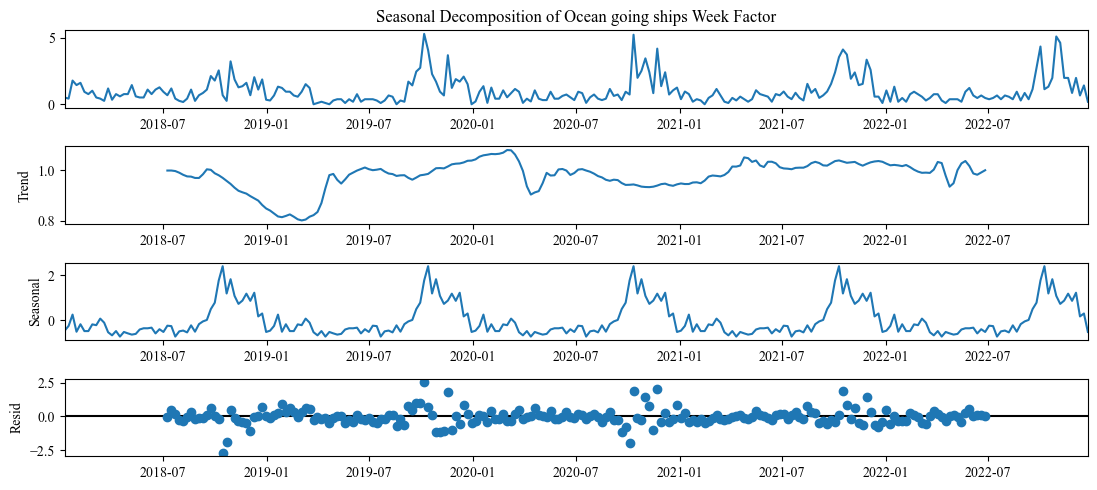

In [33]:
for cluster_checked in weeks_df_clusters['cluster'].unique():

    X_train = pd.Series(
        weeks_df_clusters[weeks_df_clusters['cluster']==cluster_checked]['week_factor']
        ).set_axis(pd_index).rename('Seasonal Decomposition of ' + cluster_names[cluster_checked] + ' Week Factor')

    decompose_result_mult = seasonal_decompose(X_train, model="additive")

    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid

    decompose_result_mult_plt = decompose_result_mult.plot()
    plt.savefig('output/figs/arrival_analysis_prediction/seasonal_decompose_cluster_' + str(cluster_checked) + '.pdf')



<a id='sarma'></a>
### 3.4. Seasonal Autoregressive Moving Average (SARMA)

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
passages =  pd.read_csv("data/passages_cleaned.csv", index_col=0)
ship_classes =  pd.read_csv("data/ship_classes.csv", index_col=0)
ship_classes_dict = ship_classes.set_index('Ship Class').to_dict('index')
del(ship_classes)
pd_index = pd.date_range(start=datetime.date(2018, 1, 1), end=datetime.date(2022, 12, 31), freq='W')


I will prepare the observations for each ship class as a time series (ts).

In [36]:
years_weeks_df_ships = pd.DataFrame(passages.groupby(['direction_id', 'sivak_class', 'year', 'week']).size()).reset_index()
# del(passages)
years_weeks_df_ships.rename(columns={0:'number_ships'}, inplace=True)
print(len(years_weeks_df_ships))

for direction in [1,3]:
    for ship_checked in years_weeks_df_ships['sivak_class'].unique():
        for year_checked in range(2018,2023):
            for week_checked in range(1,53):
                if(len(years_weeks_df_ships[(years_weeks_df_ships['direction_id']==direction) & 
                                            (years_weeks_df_ships['year']==year_checked) & 
                                            (years_weeks_df_ships['week']==week_checked) & 
                                            (years_weeks_df_ships['sivak_class']==ship_checked)]['number_ships'])==0):
                    years_weeks_df_ships = years_weeks_df_ships.append(pd.DataFrame(
                        {'direction_id': [direction], "sivak_class":[ship_checked], 'week':[week_checked], 'year':[year_checked], 'number_ships':[0]}
                        ), ignore_index = True)

years_weeks_df_ships['week_cumulative']= years_weeks_df_ships.apply(lambda x: (x['year'] - 2018)*52 + x['week'], axis=1) 
years_weeks_df_ships = years_weeks_df_ships.sort_values(by='week_cumulative')

print(len(years_weeks_df_ships))

15238
19760


In [37]:
ships_ts = {}
for direction in [1,3]:
    ships_ts[direction] = {}
    for ship_checked in years_weeks_df_ships['sivak_class'].unique():
        ships_ts[direction][ship_checked] = years_weeks_df_ships[(years_weeks_df_ships['direction_id']==direction) & 
                                                                 (years_weeks_df_ships['sivak_class']==ship_checked)].loc[:,['week_cumulative','number_ships']]
        
        ships_ts[direction][ship_checked] = pd.Series(years_weeks_df_ships[(years_weeks_df_ships['direction_id']==direction) & 
                                                                           (years_weeks_df_ships['sivak_class']==ship_checked)]['number_ships']).set_axis(pd_index)

del(years_weeks_df_ships)


Now it is time to fit the models. I will use Akaike information criterion (AIC) as the basis of selecting the best fitting model. For the first cluster, as the Autocorrelation function (ACF) graphs in [Clustering based on week factors](#clusteringbasedonweekfactors) did not show seasonal behaviour with the lag 52 weeks, I will not experiment with seasonal order parameters.

In [38]:
fitted_models = {1: {}, 3:{}}
aic_full = {1: {}, 3:{}}

for ship_checked in tqdm(list(ships_ts[direction].keys()), desc="ship loop"):
    for direction in [1,3]:
        fitted_models[direction][ship_checked] = {}
        aic_full[direction][ship_checked] = {}

        for p in range(6):
            for q in range(6):
                if p == 0 and q == 0:
                    aic_full[direction][ship_checked][p,q,0,0] = np.nan

                # Estimate the model with no missing datapoints
                mod = sm.tsa.statespace.SARIMAX(ships_ts[direction][ship_checked][:-26], order=(p,0,q), enforce_invertibility=False)
                try:
                    res = mod.fit(disp=False)
                    aic_full[direction][ship_checked][p,q,0,0] = res.aic
        
                    # fitted_models[direction][ship_checked][(p,q,0,0)] = res
                except:
                    aic_full[direction][ship_checked][p,q,0,0] = np.nan

            # print('Model search for ' + ship_checked + 'is ' + str(p+1) + '/6 completed')

        min_aic_model = min(aic_full[direction][ship_checked], key=aic_full[direction][ship_checked].get)
        fitted_models[direction][ship_checked] = min_aic_model


ship loop:   0%|          | 0/38 [00:00<?, ?it/s]

ship loop: 100%|██████████| 38/38 [17:09<00:00, 27.10s/it]


Now for the passanger ship and the see going ship, which were the clusters identified having a seasonality, I will also experiment with seasonal orders for the ARIMA model.

In [41]:
# fitted_models_best_without_seasonality = fitted_models.copy()

for ship_checked in tqdm(['passagiersschip binnnenvaart','Zeeschip Z2, 90 < L<=130'], desc="ship loop"):
    for direction in [1,3]:

        # fitted_models[direction][ship_checked] = {}
        for p in range(2):
            for q in range(2):
                for seasonal_p in range(2):
                    for seasonal_q in range(2):
                        
                        if (p, q, seasonal_p, seasonal_q) in aic_full[direction][ship_checked].keys():
                            continue
                        
                        else:
                            mod = sm.tsa.statespace.SARIMAX(ships_ts[direction][ship_checked][:-26], order=(p,0,q), 
                                                            seasonal_order=(seasonal_p, 0, seasonal_q, 52), enforce_invertibility=False)
                            try:
                                res = mod.fit(disp=False)
                                aic_full[direction][ship_checked][p,q,seasonal_p,seasonal_q] = res.aic
                                del(res)
                                # fitted_models[direction][ship_checked][(p,q,seasonal_p,seasonal_q)] = res
                            except:
                                aic_full[direction][ship_checked][p,q,seasonal_p,seasonal_q] = np.nan

            # print('Model search for ' + ship_checked + 'is ' + str(p+1) + '/3 completed')
        
        min_aic_model = min(aic_full[direction][ship_checked], key=aic_full[direction][ship_checked].get)
        #If new models have a better AIC score than fitted_models_best_without_seasonality
        # if min_aic_model[2]==0 and min_aic_model[3]==0:
        #     fitted_models[direction][ship_checked] = fitted_models_best_without_seasonality[direction][ship_checked]
        # else:
        fitted_models[direction][ship_checked] = min_aic_model


ship loop: 100%|██████████| 2/2 [01:21<00:00, 40.69s/it]


In [43]:
week_from = int(52*5)
week_to = int(52*6)

fleet_mix = pd.DataFrame(index= range(week_from, week_to), columns = [ship_checked + ' ' + str(direction) for ship_checked in ships_ts[direction].keys() for direction in [1,3]])

for ship_checked in tqdm(list(ships_ts[direction].keys()), desc="ship loop"):
    for direction in [1,3]:
        best_parameters = fitted_models[direction][ship_checked]
        p, q, seasonal_p, seasonal_q = best_parameters
        mod = sm.tsa.statespace.SARIMAX(ships_ts[direction][ship_checked][:-26], order=(p,0,q), seasonal_order=(seasonal_p, 0, seasonal_q, 52), enforce_invertibility=False)
        
        nforecast = 52 * 2
        res = mod.fit(disp=False)
        predict = res.get_prediction(end=mod.nobs + nforecast)

        for week_checked in range(week_from, week_to):
            fleet_mix.loc[week_checked,ship_checked + ' ' + str(direction)] = max(predict.predicted_mean[week_checked],0)

fleet_mix['number_arrivals'] = fleet_mix.sum(axis=1)
fleet_mix = fleet_mix.astype(float)

ship loop: 100%|██████████| 38/38 [00:47<00:00,  1.24s/it]


In [44]:
def calculate_sum(row, var_of_interest, excluded_columns):
    total_sum = 0
    for col in fleet_mix.columns:
        if (col in excluded_columns) == False:
            total_sum += row[col] * ship_classes_dict[col[:-2]][var_of_interest]
    return total_sum

In [45]:
fleet_mix['total_DWT'] = fleet_mix.apply(lambda x: calculate_sum(x, 'DWT', ['number_arrivals', 'total_DWT']), axis=1)
fleet_mix['total_area'] = fleet_mix.apply(lambda x: calculate_sum(x, 'Area', ['number_arrivals', 'total_DWT', 'total_area']), axis=1)
fleet_mix.head()


,BI-1 duwstel Europa I (IV) 1,BI-1 duwstel Europa I (IV) 3,"Zeeschip Z2, 90 < L<=130 1","Zeeschip Z2, 90 < L<=130 3",M4 (Dortmund-Emskan) (CEMT III) 1,M4 (Dortmund-Emskan) (CEMT III) 3,BII-4 duwstel Eur II 4b 1,BII-4 duwstel Eur II 4b 3,M9 (Verlengd Groot Rijnschip) 1,M9 (Verlengd Groot Rijnschip) 3,...,"C4, koppelverband, Va + 3xEur II (*) 3","C3b, koppelverband, Va + Eur II breed 1","C3b, koppelverband, Va + Eur II breed 3","C1b, koppelverband, 2 spitsen breed 1","C1b, koppelverband, 2 spitsen breed 3","C3l, koppelverband, Va + Eur II lang 1","C3l, koppelverband, Va + Eur II lang 3",number_arrivals,total_DWT,total_area
260,2.314866,1.659569,2.649375,5.281674,19.374086,22.385330,1.693083,2.088045,62.345289,64.870972,...,4.558986,11.928816,10.513978,0.023147,0.089470,17.094240,18.967853,1700.089359,4.727871e+06,2.057712e+06
261,2.265959,1.649623,1.005368,5.281711,22.764746,21.338447,1.794931,2.088034,62.329376,64.860150,...,5.471235,11.966772,10.508470,0.012199,0.088396,17.093496,19.136969,1693.976938,4.722097e+06,2.053022e+06
262,2.385755,1.639737,3.586921,5.281711,21.904015,22.061119,1.991405,2.088023,62.313467,64.849330,...,4.659145,11.600931,10.502965,0.004450,0.080063,17.074823,19.167853,1688.690090,4.714761e+06,2.047329e+06
263,2.519417,1.629910,0.968922,5.281682,20.722053,21.780008,1.878351,2.088012,62.297562,64.838511,...,4.654409,11.905338,10.497462,0.007661,0.076956,17.051421,19.324274,1689.027918,4.717790e+06,2.049728e+06
264,2.512304,1.620142,0.951437,5.281633,19.480058,22.416883,1.697117,2.088002,62.281661,64.827695,...,5.467070,11.951275,10.491963,0.016866,0.082187,17.036792,19.189895,1687.870555,4.711546e+06,2.046697e+06


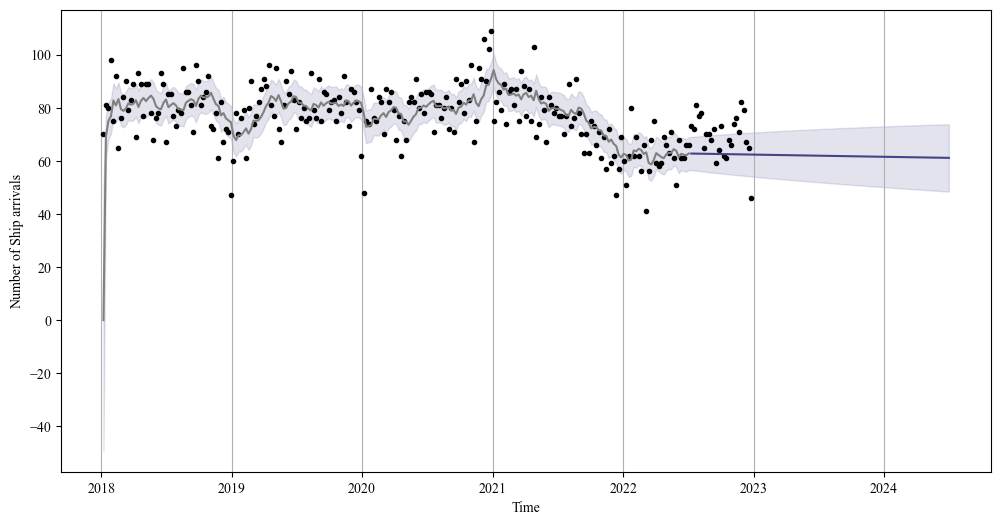

In [46]:
ship_checked = 'M9 (Verlengd Groot Rijnschip)'
direction=1

dta_full = ships_ts[direction][ship_checked][:-26]

best_parameters = fitted_models[direction][ship_checked]
p, q, seasonal_p, seasonal_q = best_parameters
mod = sm.tsa.statespace.SARIMAX(ships_ts[direction][ship_checked][:-26], order=(p,0,q), seasonal_order=(seasonal_p, 0, seasonal_q, 52), enforce_invertibility=False)

nforecast = 52 * 2
res = mod.fit(disp=False)
predict = res.get_prediction(end=mod.nobs + nforecast)

idx = predict.predicted_mean.index.to_numpy()
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(ships_ts[direction][ship_checked], 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], viridis_colors[1])
ax.fill_between(idx, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.15, color=viridis_colors[1])

ax.set_ylabel('Number of Ship arrivals')
ax.set_xlabel('Time')
plt.savefig('output/figs/arrival_analysis_prediction/sarma_historical_arrival_predictions_' + direction_dict[direction][1].lower() + ship_checked + '.pdf')

plt.show()

<a id='selectingtheweek'></a>
### 3.5. Selecting the week 

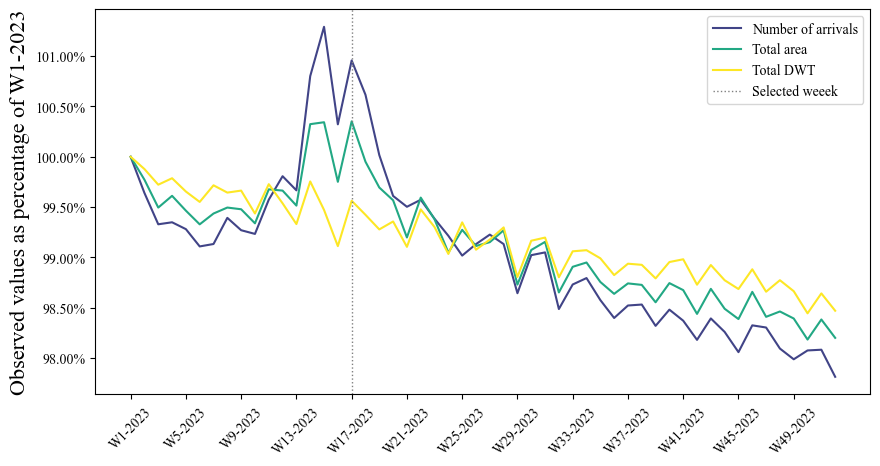

In [47]:
fleet_mix_weeklabels = list(fleet_mix.apply(lambda x: f'W{int(x.name%52)+1}-{2018+round((x.name+1)/52-0.5)}', axis=1))
fig,ax = plt.subplots(figsize=(10, 5), sharey=True)

tick_positions = range(len(fleet_mix_weeklabels))

plt.plot(tick_positions, fleet_mix['number_arrivals']/fleet_mix['number_arrivals'][260], color=viridis_colors[1], label='Number of arrivals')
plt.plot(tick_positions, fleet_mix['total_area']/fleet_mix['total_area'][260], color=viridis_colors[2], label='Total area')
plt.plot(tick_positions, fleet_mix['total_DWT']/fleet_mix['total_DWT'][260], color=viridis_colors[4], label='Total DWT')

step = 4  # Show every 5th label (adjust as needed)
plt.xticks(tick_positions[::step], fleet_mix_weeklabels[::step], rotation=45)  # Set the custom tick labels with rotation
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))

ax.set_ylabel('Observed values as percentage of W1-2023', fontsize=16)
plt.axvline(x = 16, linewidth=1, color='gray', ls=':', label='Selected weeek')
plt.legend()
plt.savefig('output/figs/arrival_analysis_prediction/predictions_number_DWT_area.pdf')
plt.show()


In [48]:
list_criteria = ['number_arrivals', 'total_DWT', 'total_area']
for criterion in list_criteria:
    print(f'{fleet_mix_weeklabels[fleet_mix[criterion].idxmax()- fleet_mix.index.start]}: '
          f'{list_criteria[0]}={round(fleet_mix.loc[fleet_mix[criterion].idxmax()][list_criteria[0]]/fleet_mix[list_criteria[0]].max(),4)} '
          f'{list_criteria[1]}={round(fleet_mix.loc[fleet_mix[criterion].idxmax()][list_criteria[1]]/fleet_mix[list_criteria[1]].max(),4)} '
          f'{list_criteria[2]}={round(fleet_mix.loc[fleet_mix[criterion].idxmax()][list_criteria[2]]/fleet_mix[list_criteria[2]].max(),4)} '
          )


W15-2023: number_arrivals=1.0 total_DWT=0.9947 total_area=0.9999 
W1-2023: number_arrivals=0.9873 total_DWT=1.0 total_area=0.9965 
W17-2023: number_arrivals=0.9967 total_DWT=0.9956 total_area=1.0 


In [69]:
print(f'Week selected is {fleet_mix_weeklabels[fleet_mix[criterion].idxmax()- fleet_mix.index.start]}')
fleet_mix_selected = fleet_mix.loc[fleet_mix[criterion].idxmax(),fleet_mix.columns[:-3]]
pd.DataFrame(fleet_mix_selected).to_csv('output/tables/baseline_fleet_mix.csv')


Week selected is W17-2023


<a id='imadrivenscenario'></a>
### 3.6. Generating IMA-driven scenario 

In [53]:
yearly_passages = pd.DataFrame(passages.groupby(['year']).size()).reset_index()
yearly_passages= yearly_passages.append(pd.DataFrame({'year': [2023], 0:[fleet_mix['number_arrivals'].sum()]}), ignore_index = True)
yearly_passages

,year,0
0,2018,108500.000000
1,2019,100284.000000
2,2020,101719.000000
3,2021,100333.000000
4,2022,90431.000000
5,2023,87590.544736


In [54]:
baseline = 106210 # value from IMA
growth_rate = pow(1.35, 1/26)

data = {'year': [], 0: []}

for year in range(2018, 2024):
    num_passages = baseline * (growth_rate ** (year - 2018))
    
    data['year'].append(year)
    data[0].append(num_passages)

yearly_passages_predicted = pd.DataFrame(data)
yearly_passages_predicted

,year,0
0,2018,106210.000000
1,2019,107443.029683
2,2020,108690.374047
3,2021,109952.199276
4,2022,111228.673482
5,2023,112519.966732


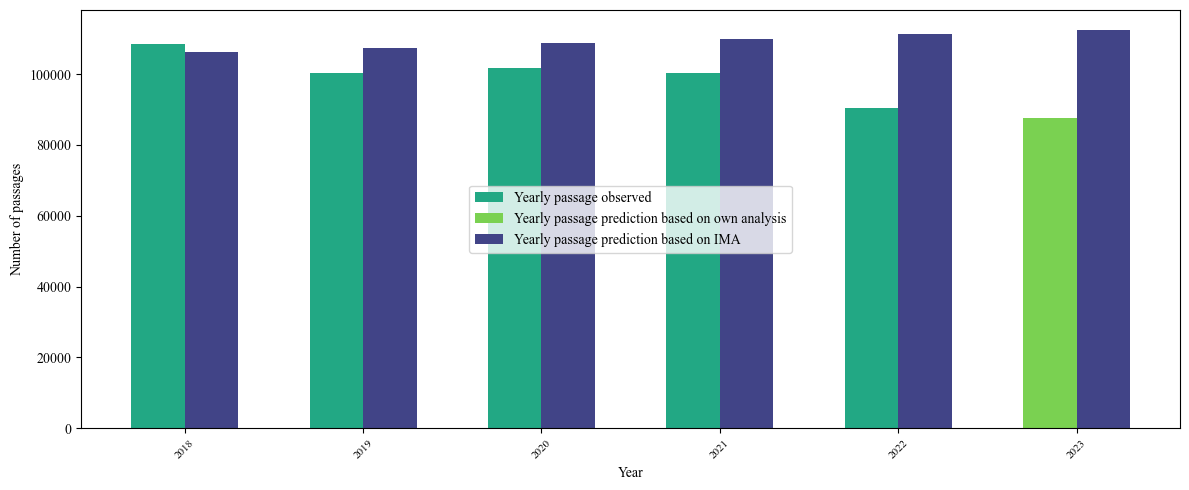

In [57]:
# Set the width of the bars
bar_width = 0.3

# Set the position of the bars on the x-axis
bar_positions = range(len(yearly_passages))

plt.figure(figsize=(12, 5))

# Shift the bar positions to the middle of each cluster
bar_positions_middle = [pos + (0.5)*bar_width for pos in bar_positions]
plt.bar(bar_positions_middle[:-1], yearly_passages[0][:-1], label='Yearly passage observed', width=bar_width, color=viridis_colors[2])
plt.bar(bar_positions_middle[-1], yearly_passages[0][5], label='Yearly passage prediction based on own analysis', width=bar_width, color=viridis_colors[3])

bar_positions_middle = [pos + (1.5)*bar_width for pos in bar_positions]
plt.bar(bar_positions_middle, yearly_passages_predicted[0], label='Yearly passage prediction based on IMA', width=bar_width, color=viridis_colors[1])


# Set x-axis labels and title
plt.xlabel('Year')
plt.xticks([pos + bar_width for pos in range(len(yearly_passages))], yearly_passages['year'], rotation=45, fontsize=8)
plt.ylabel('Number of passages')
# plt.title('Stacked Bar Chart for Each Chamber')

# Add legend for the first chamber only
plt.legend(loc='center')

# Show the plot
plt.tight_layout()
plt.savefig('output/figs/arrival_analysis_prediction/yearly_passages_prediction_baseline_vs_IMA.pdf')
plt.show()


In [58]:
container_ship_types= pd.read_csv('data/container_carrying_ship_types.csv', index_col=0)
other_ship_types = np.setdiff1d(passages.sivak_class.unique(), container_ship_types)

In [59]:
min_ton_dict = {'Container':[], 'Others':[]}
container_2014=47
others_2014=304
container_growth=1.0239
others_growth=1.0089

for i in range(2014,2024):
    min_ton_dict['Container'].append(container_2014*pow(container_growth, i-2014))
    min_ton_dict['Others'].append(others_2014*pow(others_growth, i-2014))

df = pd.DataFrame(min_ton_dict)
df.index = df.index + 2014
df['Total'] = df[['Container', 'Others']].sum(axis=1)
df[['Container', 'Others']] = df[['Container', 'Others']].div(df['Total'], axis=0) * 100
df

,Container,Others,Total
2014,13.390313,86.609687,351.000000
2015,13.562396,86.437604,354.828900
2016,13.736339,86.263661,358.708727
2017,13.912154,86.087846,362.640336
2018,14.089852,85.910148,366.624601
2019,14.269443,85.730557,370.662413
2020,14.450938,85.549062,374.754681
2021,14.634348,85.365652,378.902331
2022,14.819682,85.180318,383.106310
2023,15.006951,84.993049,387.367583


In [61]:
container_increase_percentage = []
others_decrease_percentage = []

for i in range(2014,2023):
    container_increase_percentage.append(df['Container'][i+1]/df['Container'][i])
    others_decrease_percentage.append(df['Others'][i+1]/df['Others'][i])

container_increase_percentage_avg = sum(container_increase_percentage) / len(container_increase_percentage)
others_decrease_percentage_avg = sum(others_decrease_percentage) / len(others_decrease_percentage)

print(f'{round((container_increase_percentage_avg - 1)*100,2)}% is the predicted average percentage of increase in container carrying ships')
print(f'{round((1 - others_decrease_percentage_avg)*100,2)}% is the predicted average percentage of decrease in other ship types')

1.27% is the predicted average percentage of increase in container carrying ships
0.21% is the predicted average percentage of decrease in other ship types


In [62]:
container_ship_types_with_dir = []
for i, item in enumerate(container_ship_types):
    container_ship_types_with_dir.append(f'{item} 1')
    container_ship_types_with_dir.append(f'{item} 3')

other_ship_types_with_dir = []
for i, item in enumerate(other_ship_types):
    other_ship_types_with_dir.append(f'{item} 1')
    other_ship_types_with_dir.append(f'{item} 3')

In [68]:
ima_driven_fleet_mix = fleet_mix_selected.copy()
ima_driven_fleet_mix.loc[container_ship_types_with_dir] = ima_driven_fleet_mix.loc[container_ship_types_with_dir]*container_increase_percentage_avg
ima_driven_fleet_mix.loc[other_ship_types_with_dir] = ima_driven_fleet_mix.loc[other_ship_types_with_dir]*others_decrease_percentage_avg
ima_driven_fleet_mix = ima_driven_fleet_mix * (yearly_passages_predicted[0][5]/yearly_passages[0][5])
ima_driven_fleet_mix.sum()

2200.2357160066845

In [70]:
pd.DataFrame(ima_driven_fleet_mix).to_csv('output/tables/ima_driven_fleet_mix.csv')